In [91]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'
import scipy.stats as ss
from scipy.stats import norminvgauss
import statsmodels.graphics.gofplots

from arch import arch_model 
import yfinance as yf

In [14]:
import yfinance as yf
start_date='2018-07-01'
end_date='2022-06-30'
Amazon_data = yf.download('AMZN', start=start_date, end=end_date)
Amazon_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-02,84.135002,85.694504,83.903000,85.689003,85.689003,63714000
2018-07-03,86.197998,86.250000,84.624001,84.697998,84.697998,43546000
2018-07-05,85.268997,85.534500,84.107498,84.986504,84.986504,59662000
2018-07-06,84.800003,85.763496,84.583504,85.531502,85.531502,53006000
2018-07-09,86.202499,86.977997,85.811501,86.950996,86.950996,60240000


### Графики цены закрытия и скорректированной цены

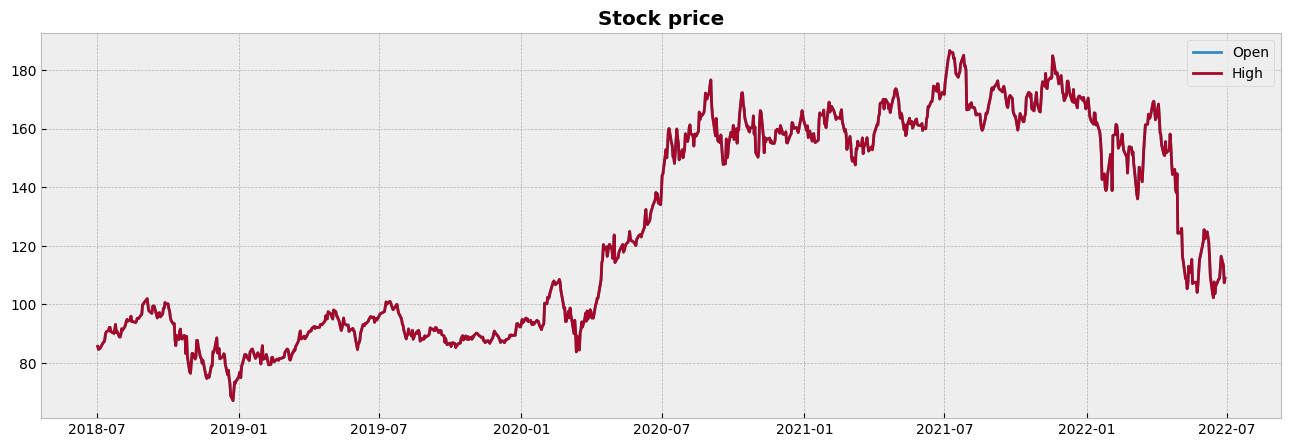

In [15]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(Amazon_data[plot_fields])
plt.legend(Amazon_data)

plt.title("Stock price", weight="bold")

plt.show()

### Предобработка данных и построение графика доходностей

In [16]:
Amazon_data.index = Amazon_data.index.to_period(freq='d') # устанавливаем частотность в 1 день
#print(Amazon_data.index)

# цены
price = Amazon_data['Adj Close']
#price.head()

# процентное изменение
ret = price.pct_change() 
#ret.head()

# удаление строк с пустыми значениями
ret.dropna(inplace=True) 

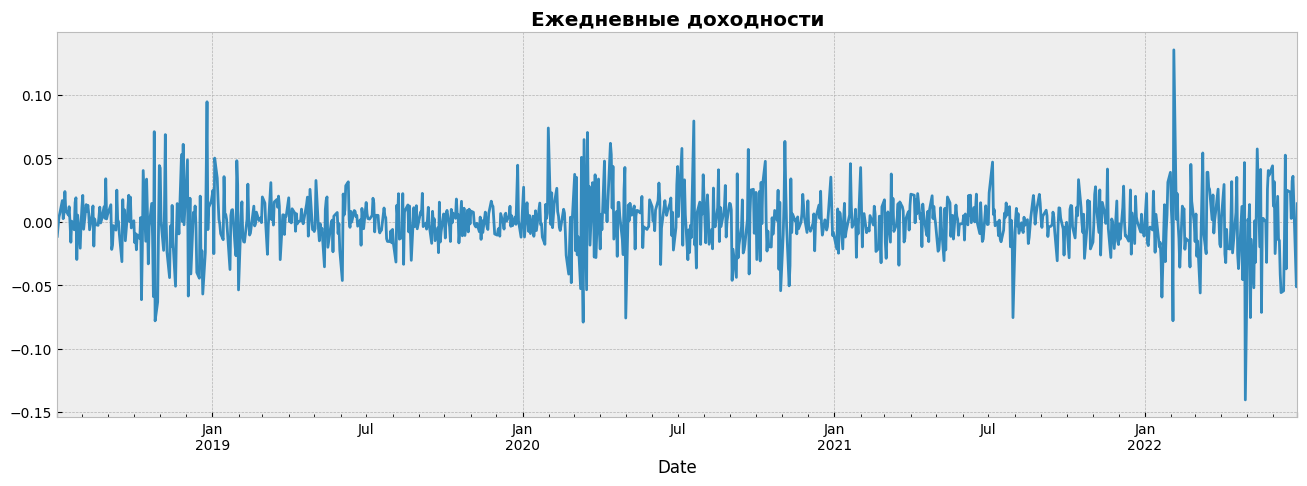

In [17]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Ежедневные доходности", weight="bold")

plt.show()

### Построение гистограмм и графика квантиль-квантиль (Q-Q plot)

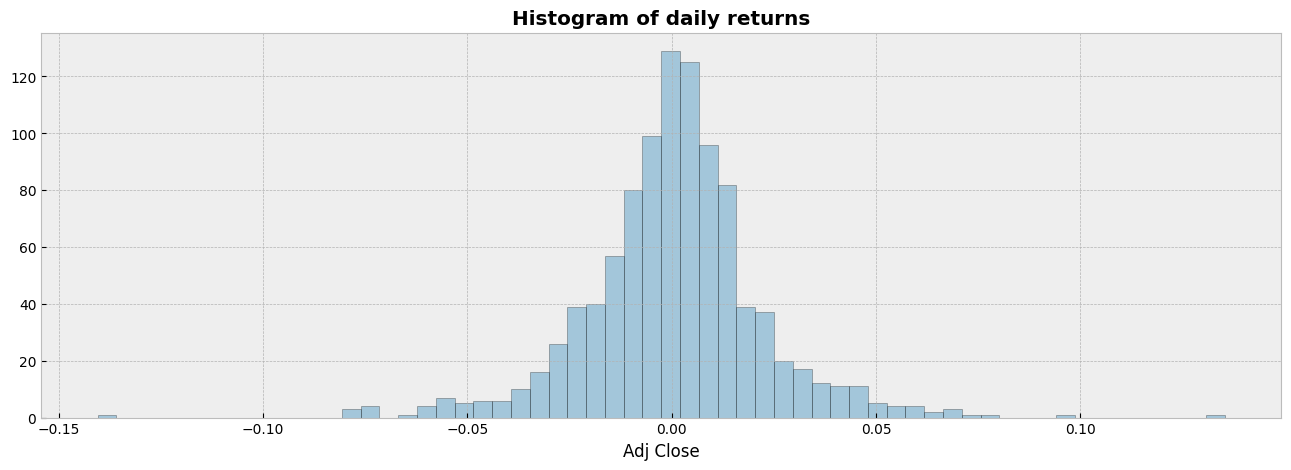

In [89]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

#### Проверим является ли распределение доходносте нормальным

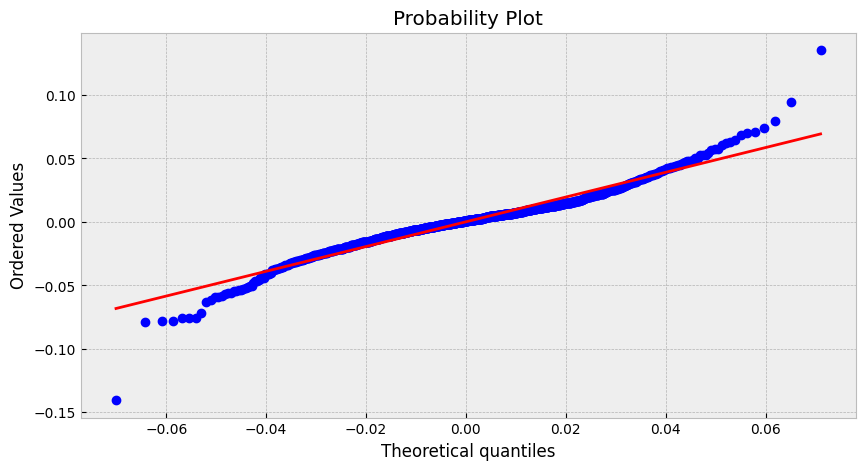

In [90]:
params_norm = ss.norm.fit(ret)

fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)
plt.show()

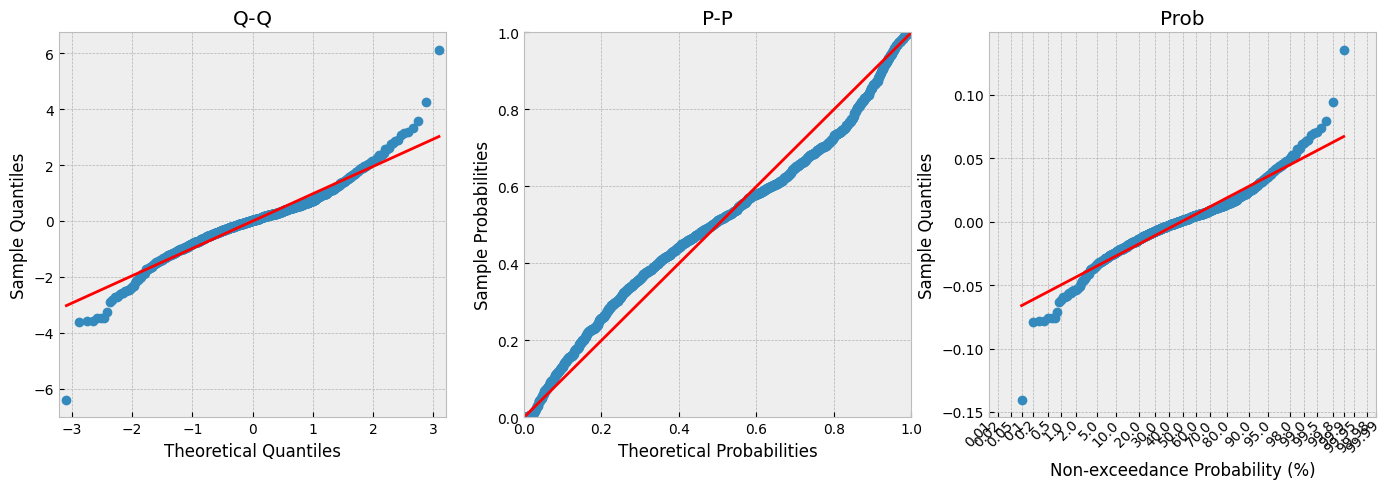

In [92]:
pp = statsmodels.graphics.gofplots.ProbPlot(ret, fit=True)

fig = plt.figure(figsize=(17, 5))
plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

pp.qqplot(ax=plt1.axes, line='r')
plt1.set_title('Q-Q')

pp.ppplot(ax=plt2.axes, line='45')
plt2.set_title('P-P')

pp.probplot(ax=plt3.axes, line='r')
plt3.set_title('Prob')

plt.show()

Видно, что хвосты распределений отличаются заметно друг от друга.

## Риск-метрики

### а) Value-at-Risk

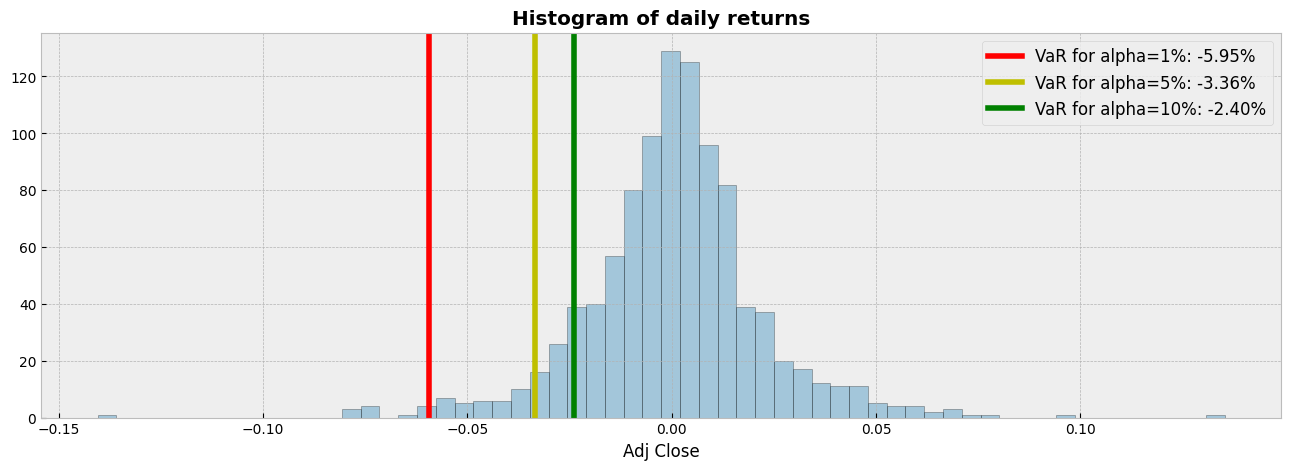

In [93]:
# визуализация VaR
VaR_HS_01 = ret.quantile(0.01)
VaR_HS_05 = ret.quantile(0.05)
VaR_HS_10 = ret.quantile(0.10)

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

plt.title("Histogram of daily returns", weight="bold")

plt.legend(['VaR for alpha=1%: {:.2f}%'.format(100*VaR_HS_01),
            'VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05),
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS_10)], fontsize=12)

plt.show()

### б) Expected Shortfall

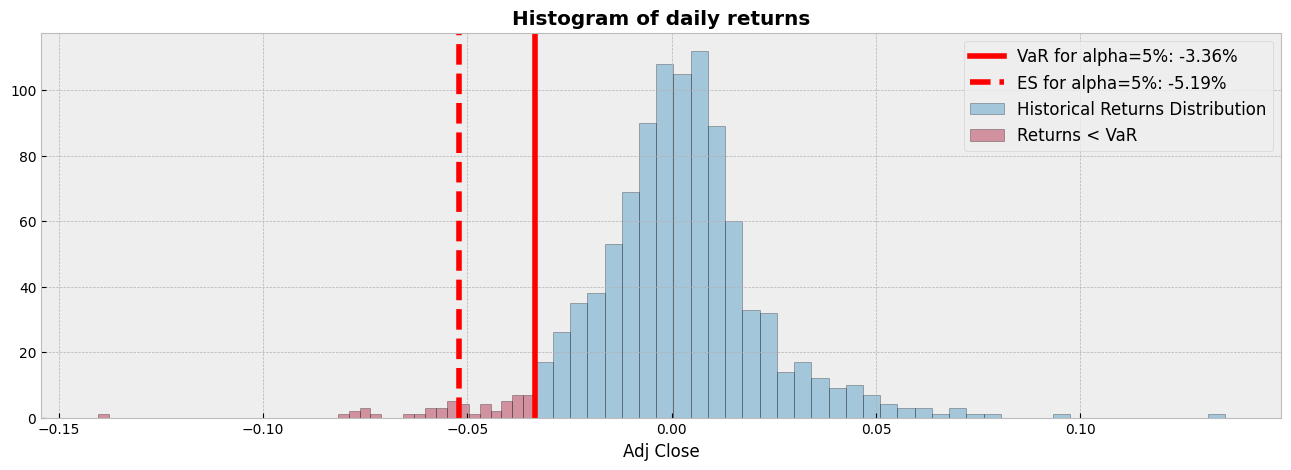

In [112]:
# визуализация ES для alpha = 0.5

ALPHA = 0.05 # уровень доверия

VaR_HS05 = ret.quantile(ALPHA)
ES_HS05 = ret[ret < VaR_HS05].mean()

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS05], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS05], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS05, linewidth=4, color="r")
plt.axvline(ES_HS05, linewidth=4, color='red', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS05),
            'ES for alpha=5%: {:.2f}%'.format(100*ES_HS05),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

# Моделирование VaR

In [113]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    '''
    функция для вычисления VaR для любого из подходов
    '''
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

### 1) Исторический подход

In [114]:
# вычисление VaR историческим подходом
def calculate_VaR_HS(ret, alpha=0.05):
    return ret.quantile(alpha)

In [115]:
# непосредственно вычисление
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=ALPHA)

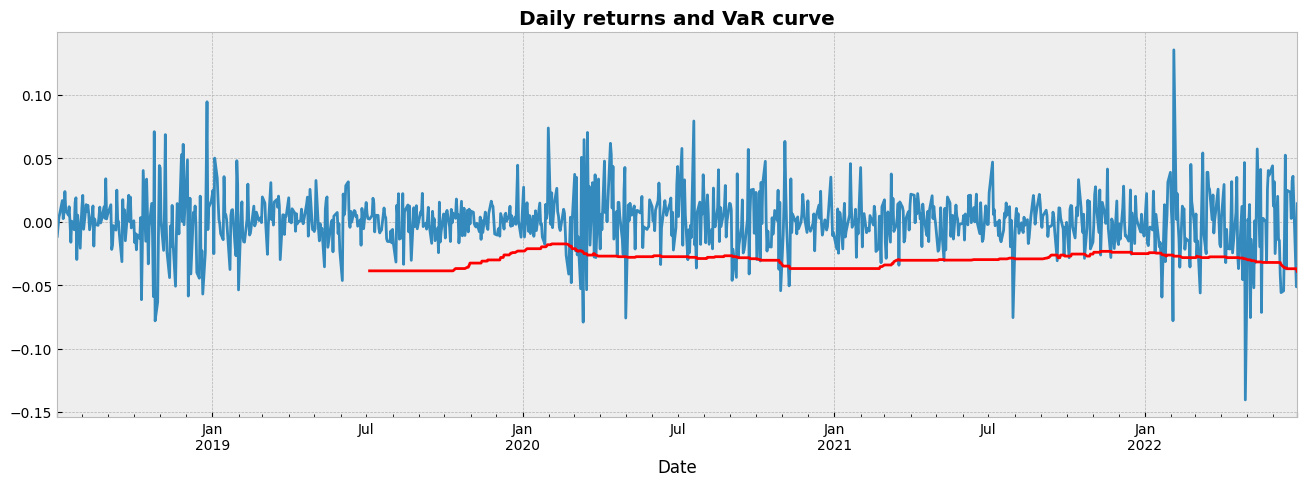

In [116]:
# график доходности акции и VaR
fig = plt.figure(figsize=(16, 5))
ret.plot()
VaR_HS.plot(color='r')
plt.title("Daily returns and VaR curve", weight="bold")
plt.show()

### 2) Параметрические методы (подгоняется распределение доходностей акции под рассматриваемое распределение, для которого берется квантиль) 

#### а) Нормальное распределение

In [26]:
# пример расчета VaR акции на основе данных за весь исследуемый период

params_norm = ss.norm.fit(ret)
norm_mean, norm_sigma = params_norm

VaR_norm = ss.norm.ppf(ALPHA, norm_mean, norm_sigma)
ES_norm = ss.norm.expect(loc=norm_mean, scale=norm_sigma, ub=VaR_norm, conditional=True)

print('Estimated parameters: mean={:.2f}, scale={:.2f}'.format(norm_mean, norm_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_norm))
print('Expected Shortfall: {:.2f}%'.format(100*ES_norm))

Estimated parameters: mean=0.00, scale=0.02
Value-at-Risk: -3.58%
Expected Shortfall: -4.50%


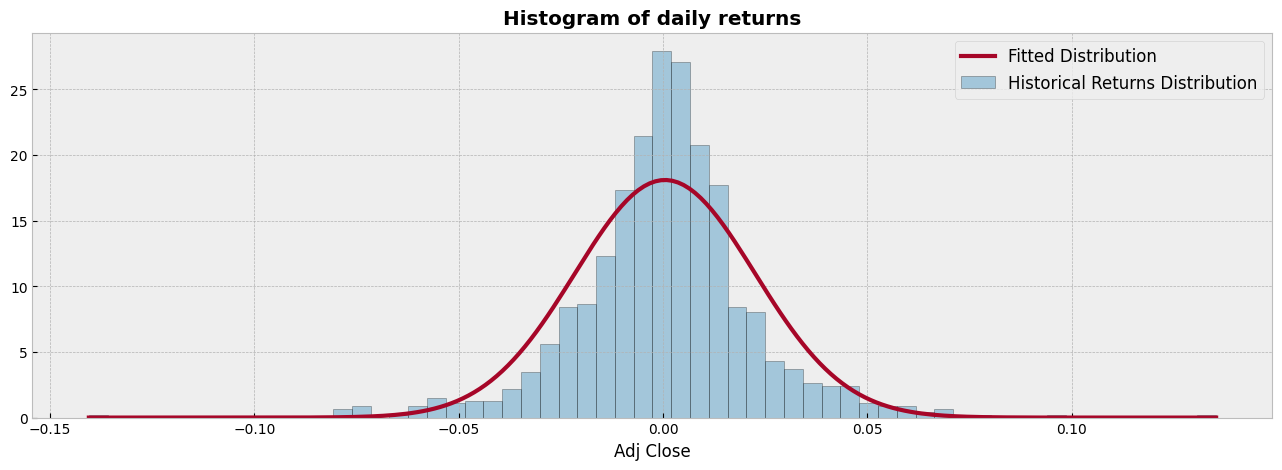

In [28]:
# визуализация того, как удается подогнать распределение доходностей акции под нормальное распределение (видно, что результат 
# не очень)

fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)
y_pdf = ss.norm.pdf(x, *params_norm)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})

plt.plot(x, y_pdf, linewidth=3)
plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)
plt.show()

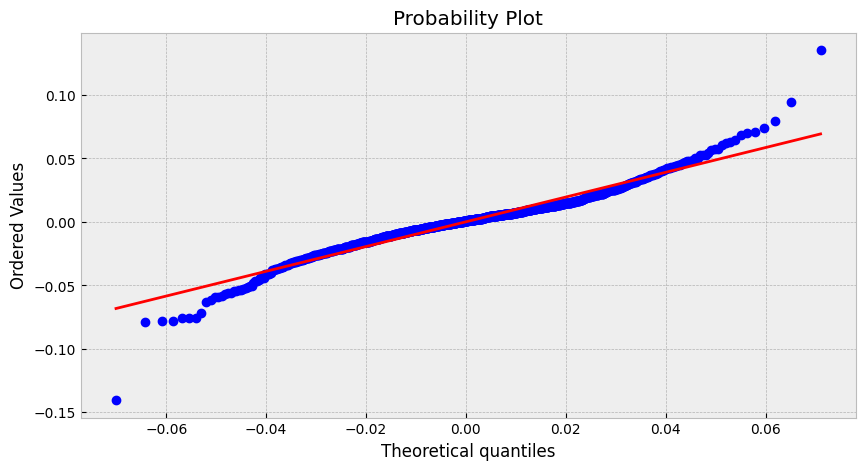

In [29]:
# P-P plot (видно, что реальные доходности (синие точки) не совсем хорошо ложатся на красную прямую для нормального 
# распределения)
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)
plt.show()

#### б)  Распределение Стьюдента

In [31]:
# по аналогии как ранее пример расчета VaR акции на основе данных за весь исследуемый период
params_t = ss.t.fit(ret)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(ALPHA, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=3.13, mean=0.00, scale=0.01
Value-at-Risk: -3.27%
Expected Shortfall: -5.35%


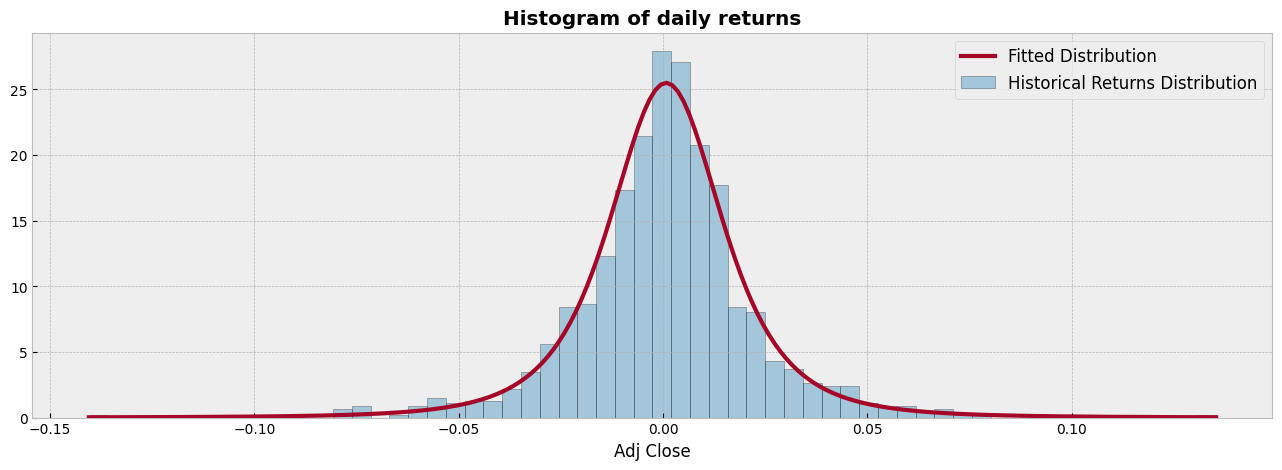

In [32]:
# визуализация подгона распределения доходностей акции под распределение Стьюдента (видно, что результат уже лучше)
fig = plt.figure(figsize=(16, 5))
x = np.linspace(ret.min(), ret.max(), 200)
y_pdf = ss.t.pdf(x, *params_t)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})

plt.plot(x, y_pdf, linewidth=3)
plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)
plt.show()

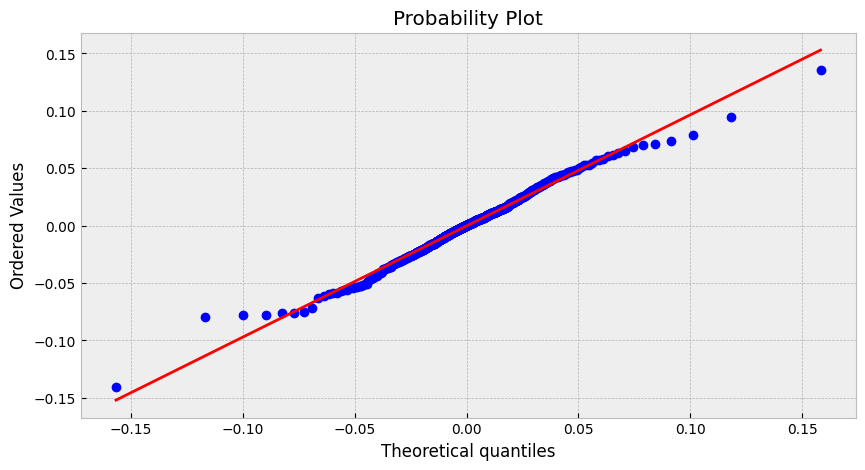

In [33]:
# P-P plot (видно, что синие точки уже почти все лежат на красной прямой, кроме "хвостов")
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.t(*params_t), plot=plt)
plt.show()

#### в) Обратное гауссово распределение

In [76]:
norminv_params = norminvgauss.fit(ret)

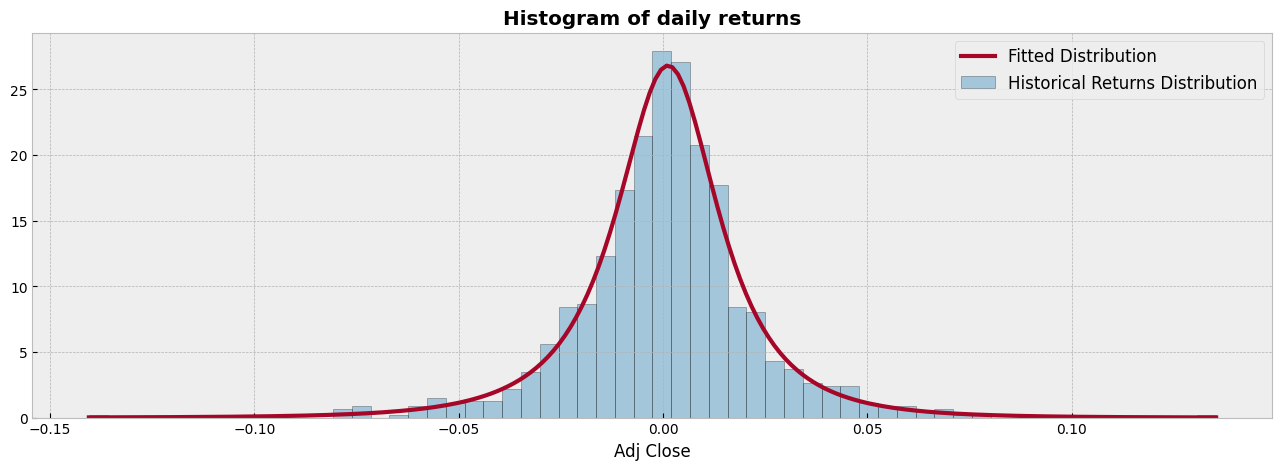

In [77]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = norminvgauss.pdf(x, *norminv_params)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()

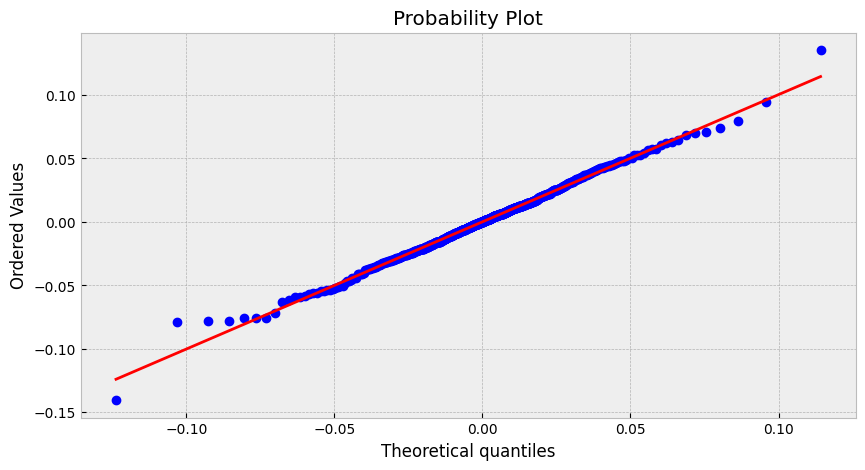

In [78]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=norminvgauss(*norminv_params), plot=plt)
plt.show()

In [80]:
# функции для расчета VaR акции с помощью нормального распределения, распределения Стьюдента и обратного гауссова распределения

def calculate_VaR_normal(ret, alpha=0.05):
    params_norm = ss.norm.fit(ret)
    return ss.norm.ppf(alpha, *params_norm)

def calculate_VaR_t(ret, alpha=0.05):
    params_t = ss.t.fit(ret)
    return ss.t.ppf(alpha, *params_t)

def calculate_VaR_norminv(ret, alpha=0.05):
    norminv_params = norminvgauss.fit(ret)
    params_norm = ss.norm.fit(ret)
    return norminvgauss.ppf(alpha, *norminv_params)

In [81]:
# непосредственно расчет VaR
VaR_norm = calc_VaR(ret, calculate_VaR_normal, L_history=252, level=ALPHA)
VaR_t = calc_VaR(ret, calculate_VaR_t, L_history=252, level=ALPHA)
VaR_norminv = calc_VaR(ret, calculate_VaR_norminv, L_history=252, level=ALPHA)

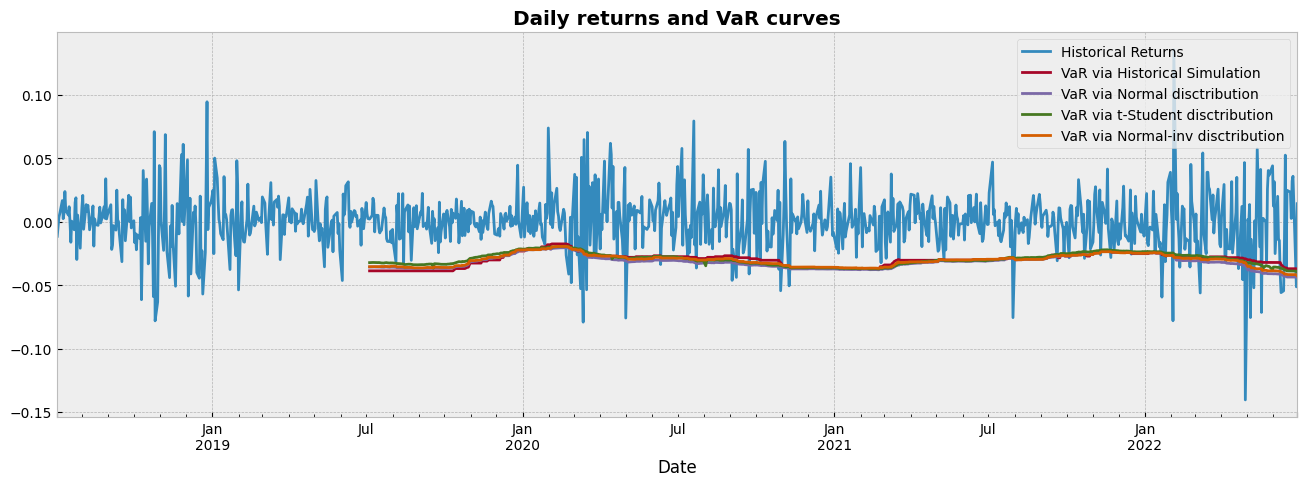

In [82]:
# визуализация доходности акции и VaR, вычисленное историческим подходом и параметрическими методами
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
VaR_norm.plot()
VaR_t.plot()
VaR_norminv.plot()
plt.title("Daily returns and VaR curves", weight="bold")
plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Normal disctribution',
            'VaR via t-Student disctribution',
            'VaR via Normal-inv disctribution'])

plt.show()

Особой разницы нет. Ниже будет проводиться бэктестирование и выясним какой подход лучше.

### 3) С использование теории экстремальных значений (EVT)

#### а) Блочные максимумы (Block maxima) и Обобщенное распределение экстремальных значений (GEV)

In [45]:
# Семплируем потери по периодам (напр. неделя, месяц и т.д.) и ищем максимально отрицательные доходности в каждом
maximas = ret.resample('W').min()

In [49]:
# GEV
params_genextreme = ss.genextreme.fit(maximas)
c, loc, scale = params_genextreme
xi = -c

VaR_genextreme = loc + scale / xi * (1 - (-5*np.log(1-ALPHA)) ** (-xi) )

print('Estimated parameters: c={:.2f}, mean={:.2f}, scale={:.2f}'.format(c, loc, scale))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_genextreme))


Estimated parameters: c=0.67, mean=-0.03, scale=0.02
Value-at-Risk: -4.37%


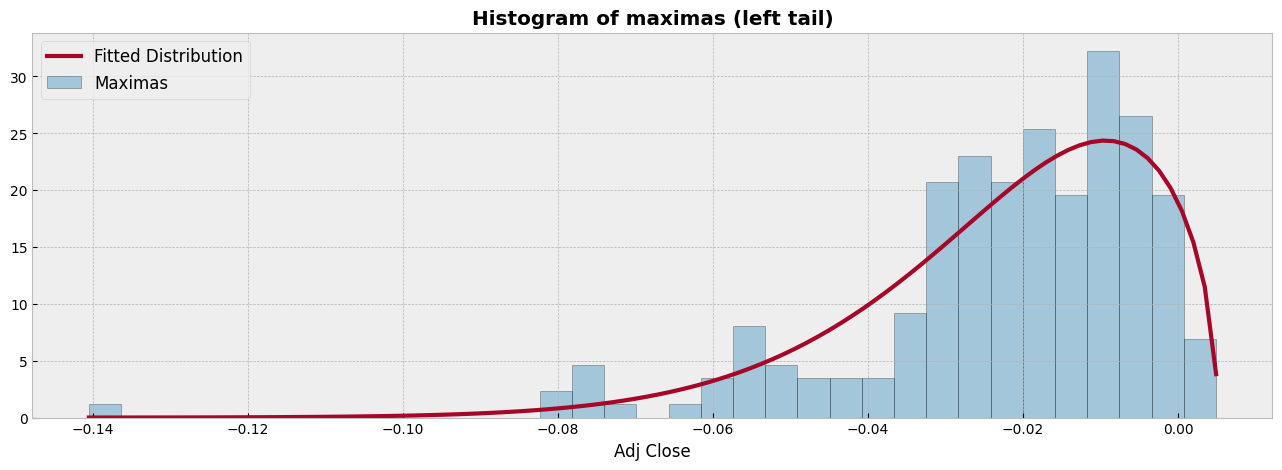

In [51]:
# визуализация подгона распределения "минимумов" доходностей акции под GEV 
fig = plt.figure(figsize=(16, 5))

x = np.linspace(maximas.min(), maximas.max(), 100)
y_pdf = ss.genextreme.pdf(x, *params_genextreme)

sns.distplot(maximas, hist=True, kde=False, 
             bins=35, norm_hist=True,
             hist_kws={'edgecolor':'black'})

plt.plot(x, y_pdf, linewidth=3)
plt.title("Histogram of maximas (left tail)", weight="bold")
plt.legend(['Fitted Distribution', 'Maximas'], fontsize=12)

plt.show()

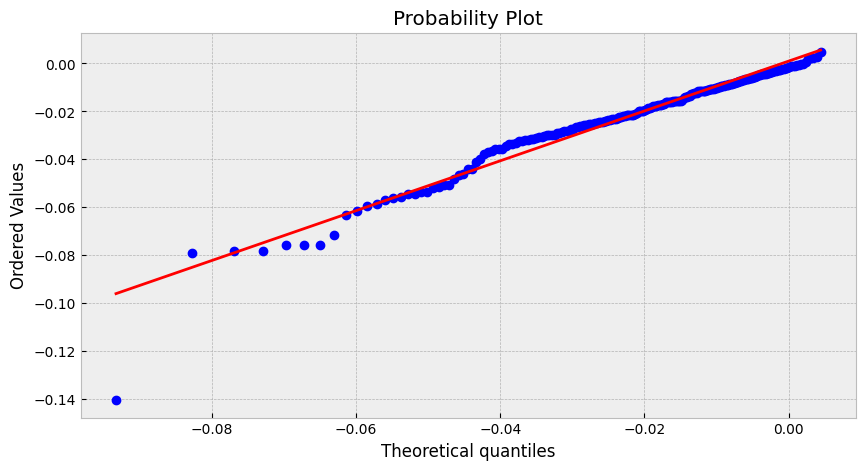

In [52]:
# P-P plot (очень хороший результат справа, но сильные расхождения в хвосте)
fig = plt.figure(figsize=(10, 5))
ss.probplot(maximas, dist=ss.genextreme(*params_genextreme), plot=plt)
plt.show()

#### б) Распределение сверх порогового значения (Excess Distribution Over a Threshold)

In [53]:
u = ret.quantile(0.2)
print(u)
ret_tail = ret[ret <= u]

-0.01381487569763884


In [55]:
# Обобщенное распределение Парето (GPD)
params_genpareto = ss.genpareto.fit(-ret_tail, loc=0)
c, loc, scale = params_genpareto

VaR_genpareto = u - scale / c * ((ALPHA/(ret <= u).mean())**(-c) - 1)
ES_genpareto = VaR_genpareto / (1 - c) - (scale - c*u) / (1 - c)

print('Estimated parameters: c={:.2f}, mean={:.2f}, scale={:.2f}'.format(c, loc, scale))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_genpareto))
print('Expected Shortfall: {:.2f}%'.format(100*ES_genpareto))

Estimated parameters: c=0.07, mean=0.01, scale=0.01
Value-at-Risk: -3.48%
Expected Shortfall: -5.40%


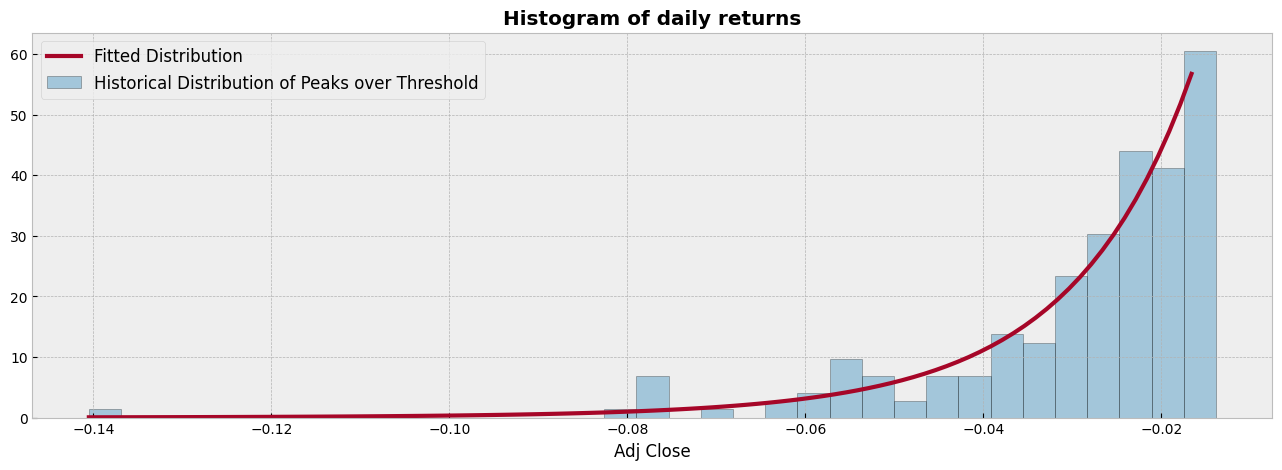

In [57]:
# визуализация подгона хвоста распределения доходностей акции под GPD
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret_tail.min(), ret_tail.max()*1.2, 100)
y_pdf = ss.genpareto.pdf(-x, *params_genpareto)

sns.distplot(ret_tail, hist=True, kde=False, 
             bins=35, norm_hist=True,
             hist_kws={'edgecolor':'black'})

plt.plot(x, y_pdf, linewidth=3)
plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Distribution of Peaks over Threshold'], fontsize=12)

plt.show()

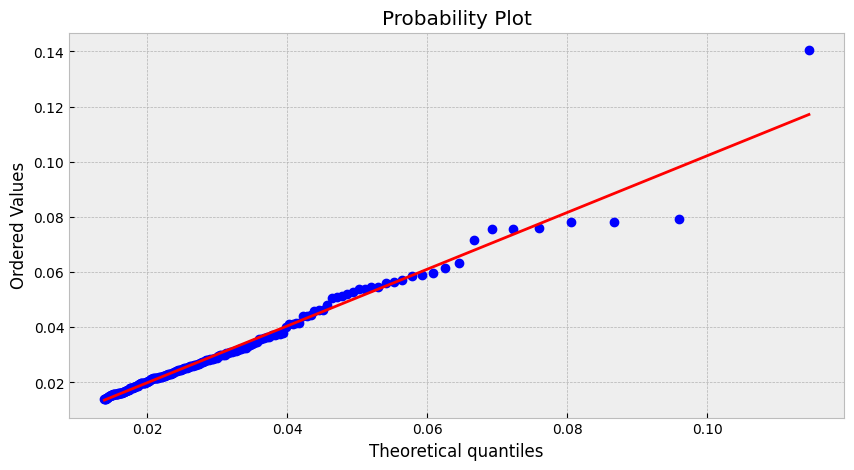

In [59]:
# P-P plot (Неплохой результат слева, однако сильные расхождения справа)
fig = plt.figure(figsize=(10, 5))
ss.probplot(-ret_tail, dist=ss.genpareto(*params_genpareto), plot=plt)
plt.show()

In [60]:
# функции для расчета VaR акции с помощью рассмотренных двух методов теории экстремальных значений
def calculate_VaR_pot(ret, alpha=0.05):
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]
    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)


def calculate_VaR_maximas(ret, alpha=0.05):
    maximas = ret.resample('W').min()
    params_genextreme = ss.genextreme.fit(maximas)
    c, loc, scale = params_genextreme
    xi = -c
    return loc + scale / xi * (1 - (-5*np.log(1-alpha)) ** (-xi) )

In [62]:
# Непосредственно вычисление VaR
VaR_pot = calc_VaR(ret, calculate_VaR_pot, L_history=252, level=ALPHA)
VaR_maximas = calc_VaR(ret, calculate_VaR_maximas, L_history=252, level=ALPHA)

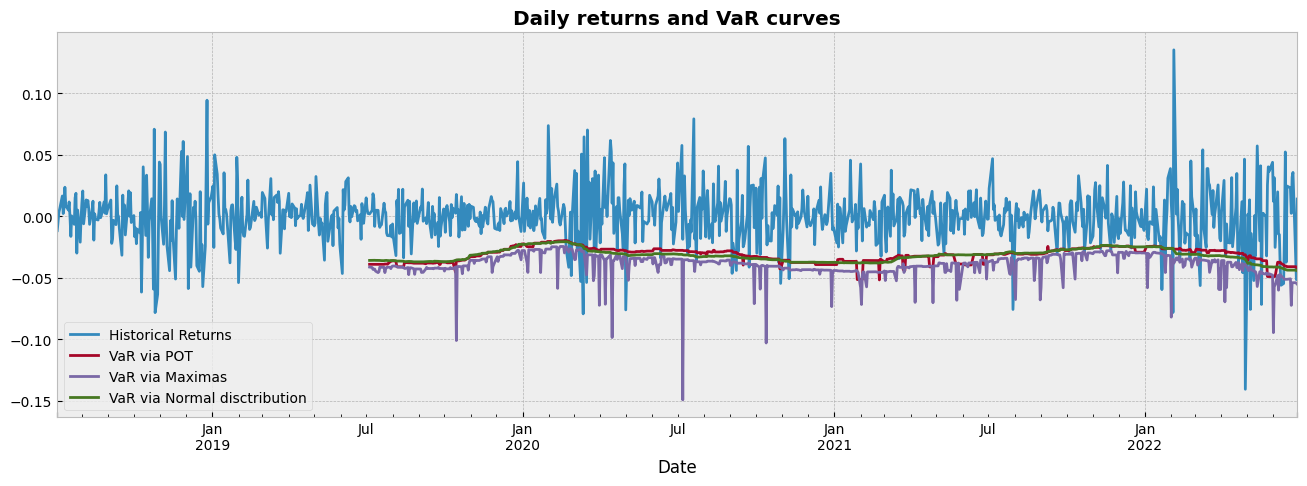

In [63]:
# визуализация доходности акции и VaR, вычисленное историческим подходом и с помощью методов теории экстремальных значений
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_pot.plot()
VaR_maximas.plot()
VaR_norm.plot()

plt.title("Daily returns and VaR curves", weight="bold")
plt.legend(['Historical Returns',
            'VaR via POT',
            'VaR via Maximas', 
            'VaR via Normal disctribution'])

plt.show()

Очень интересные зависимости получилось: не такие плавные, так при использовании параметрических подходов. Ниже будет проводиться бэктестирование.

### 4) Использование GARCH - моделей

#### а) GARCH с параметрическим распределением остатков

In [64]:
dist = 'skewstudent'

mdl = arch_model(100 * ret,
                 mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                 vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                 dist=dist) # dist = Normal, t, skewstudent, ged

res = mdl.fit()
res

Iteration:      1,   Func. Count:     10,   Neg. LLF: 35738.91874067108
Iteration:      2,   Func. Count:     22,   Neg. LLF: 85242.31447282215
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4032.751256436981
Iteration:      4,   Func. Count:     46,   Neg. LLF: 27269.049823051264
Iteration:      5,   Func. Count:     57,   Neg. LLF: 13750.526078752122
Iteration:      6,   Func. Count:     68,   Neg. LLF: 2095.9568282384002
Iteration:      7,   Func. Count:     78,   Neg. LLF: 3052.323247825356
Iteration:      8,   Func. Count:     88,   Neg. LLF: 2072.167215718964
Iteration:      9,   Func. Count:     98,   Neg. LLF: 2077.2020748896584
Iteration:     10,   Func. Count:    108,   Neg. LLF: 2074.072522331364
Iteration:     11,   Func. Count:    118,   Neg. LLF: 2061.6460669795506
Iteration:     12,   Func. Count:    128,   Neg. LLF: 2061.6258968389902
Iteration:     13,   Func. Count:    138,   Neg. LLF: 2061.540580249766
Iteration:     14,   Func. Count:    147,   Neg. LLF: 2061

                              HAR - GJR-GARCH Model Results                              
Dep. Variable:                         Adj Close   R-squared:                      -0.000
Mean Model:                                  HAR   Adj. R-squared:                 -0.001
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2061.54
Distribution:      Standardized Skew Student's t   AIC:                           4139.08
Method:                       Maximum Likelihood   BIC:                           4178.37
                                                   No. Observations:                 1004
Date:                           Sat, May 13 2023   Df Residuals:                     1002
Time:                                   01:47:05   Df Model:                            2
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------

Рассмотрим условную волатильность и стандартизированные остатки

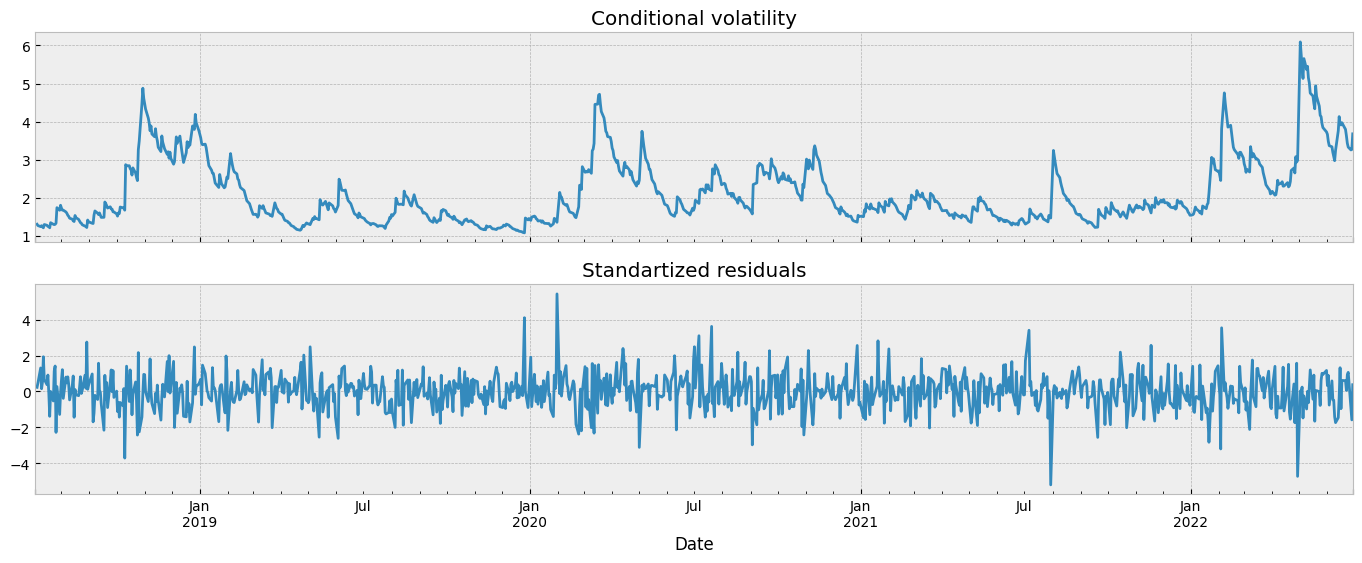

In [65]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standartized residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

Предсказываем условное среднее и дисперсию

In [66]:
my_forecast = res.forecast(horizon=5)

print(my_forecast.mean.tail(4))
print(my_forecast.variance.tail(4))

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2022-06-24       NaN       NaN       NaN       NaN       NaN
2022-06-27       NaN       NaN       NaN       NaN       NaN
2022-06-28       NaN       NaN       NaN       NaN       NaN
2022-06-29  0.046882  0.046527  0.046527  0.046527  0.046527
                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2022-06-24        NaN        NaN        NaN        NaN        NaN
2022-06-27        NaN        NaN        NaN        NaN        NaN
2022-06-28        NaN        NaN        NaN        NaN        NaN
2022-06-29  12.186903  12.131067  12.075912  12.021431  11.967616


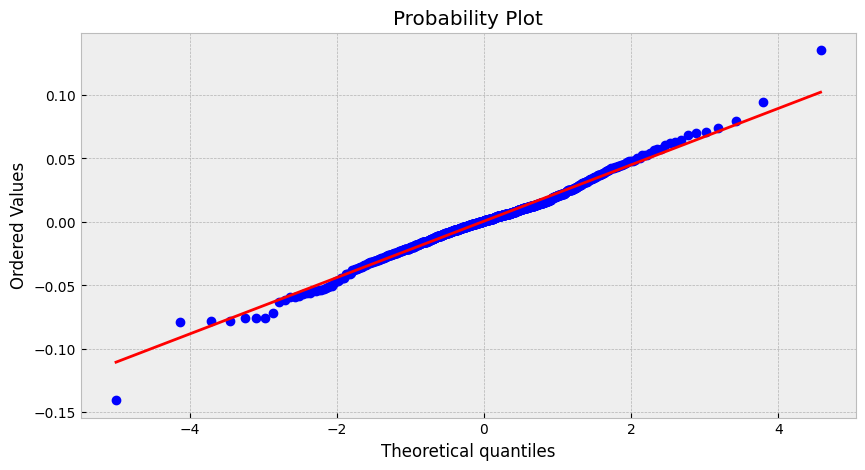

In [67]:
# P-P plot (Видим, что уже лучше, чем в предыдущих случаях)
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=mdl.distribution, sparams=(res.params[-2:],), plot=plt)
plt.show()

#### б) с фильтрацией временных рядов (Filtered Historical Simulation)

In [69]:
# обучаем модель с нормальным распределением остатков
mdl = arch_model(100 * ret,
                    mean='Constant', lags=1, 
                    vol='Garch', p=2, o=2, q=2, 
                    dist='normal')

res = mdl.fit(disp='off')

# получаем стандартизированные остатки
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

# предсказываем среднее и десперсию на один шаг вперед
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])

# получаем предсказанные условные доходности
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100

# считаем VaR как квантиль
VaR_FHS = conditional_sr.quantile(ALPHA)

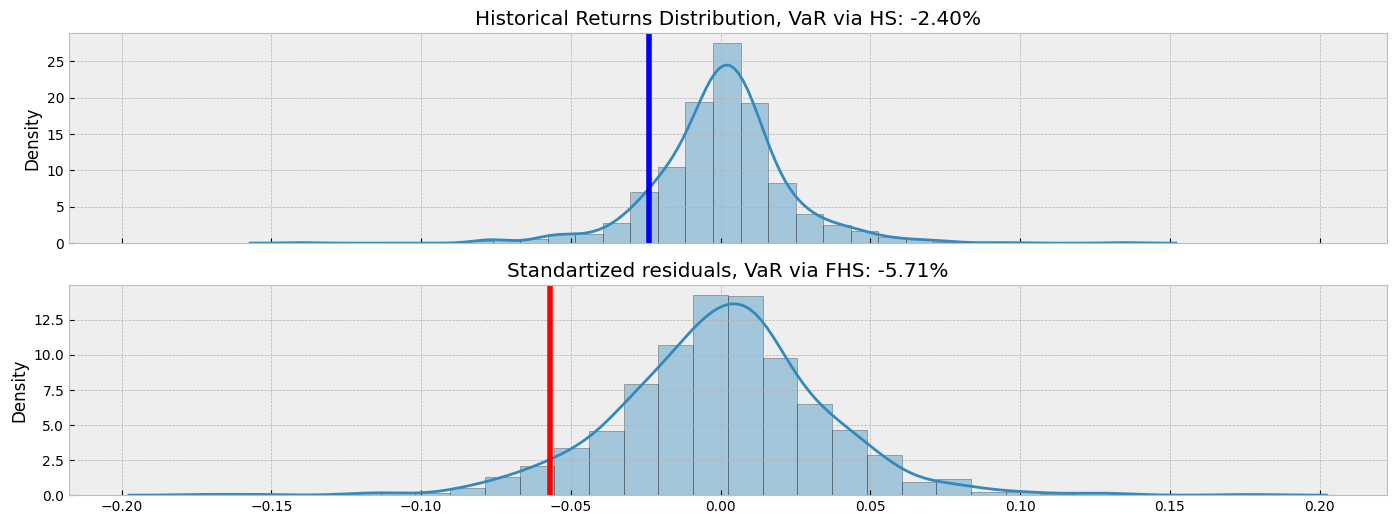

In [71]:
# визуализация 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*ret.quantile(0.10)))
ax[0].axvline(x=ret.quantile(0.10), linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_FHS))
ax[1].axvline(x=VaR_FHS, linewidth=4, color="r")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

In [72]:
# функции для расчета VaR акции с помощью рассмотренных двух методов с использованием GARCH - модели
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast


def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # получаем стандартизированные остатки
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


   # предсказываем средднее и десперсию на один шаг вперед
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем предсказанные условные доходности
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # считаем VaR как квантиль
    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

#### в) GARCH + EVT

In [85]:
def calculate_VaR_EVT(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, 
                    vol='Garch', p=1, o=1, q=1, 
                    dist='normal')

    res = mdl.fit(disp='off')

   # получаем стандартизированные остатки
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()

   # предсказываем среднее и десперсию на один шаг вперед
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем предсказанные условные доходности
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # считаем VaR 
    VaR_EVT = calculate_VaR_pot(conditional_sr, alpha=0.05)

    return VaR_EVT

In [87]:
# непосредственно вычисление VaR
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=ALPHA)
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=ALPHA)
VaR_garch_evt = calc_VaR(ret, calculate_VaR_EVT, L_history=252, level=ALPHA)

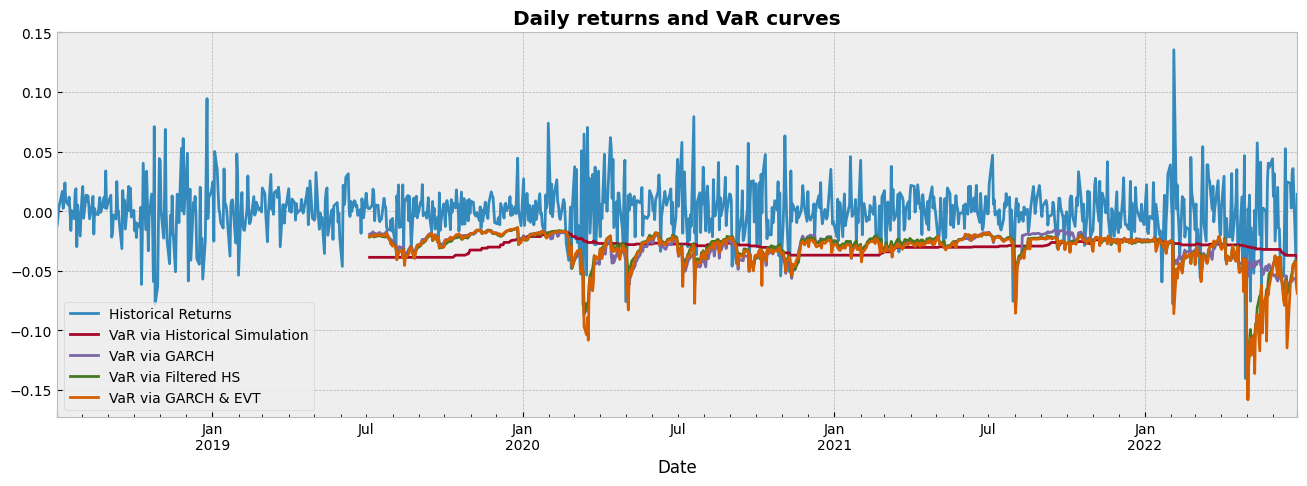

In [88]:
# визуализация доходности акции и VaR, вычисленное историческим подходом и с помощью GARCH - моделей
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
VaR_garch.plot()
VaR_FHS.plot()
VaR_garch_evt.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
           'VaR via Filtered HS',
           'VaR via GARCH & EVT'])

plt.show()

## Бэктестирование 

In [100]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [101]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [102]:
def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [117]:
backtest_VaR(ret, VaR_HS, 1-alpha)

backtest_VaR(ret, VaR_norm, 1-alpha)
backtest_VaR(ret, VaR_t, 1-alpha)
backtest_VaR(ret, VaR_norminv, 1-alpha)

backtest_VaR(ret, VaR_pot, 1-alpha)
backtest_VaR(ret, VaR_maximas, 1-alpha)

backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_FHS, 1-alpha)
backtest_VaR(ret, VaR_garch_evt, 1-alpha)

Backtesting calculate_VaR_HS:
The proportion of hits is 7.44% instead of expected 5.0%
Two-sided p-val 0.00337, one-sided: 0.0024
yellow zone

Backtesting calculate_VaR_normal:
The proportion of hits is 5.71% instead of expected 5.0%
Two-sided p-val 0.357, one-sided: 0.206
green zone

Backtesting calculate_VaR_t:
The proportion of hits is 6.91% instead of expected 5.0%
Two-sided p-val 0.0234, one-sided: 0.0131
yellow zone

Backtesting calculate_VaR_norminv:
The proportion of hits is 6.51% instead of expected 5.0%
Two-sided p-val 0.0652, one-sided: 0.0388
green zone

Backtesting calculate_VaR_pot:
The proportion of hits is 6.51% instead of expected 5.0%
Two-sided p-val 0.0652, one-sided: 0.0388
green zone

Backtesting calculate_VaR_maximas:
The proportion of hits is 3.85% instead of expected 5.0%
Two-sided p-val 0.156, one-sided: 0.942
green zone

Backtesting calculate_VaR_garch:
The proportion of hits is 5.98% instead of expected 5.0%
Two-sided p-val 0.21, one-sided: 0.127
green zone



### Выводы

Односторонний биномиальный тест:

H_0: ожидаемая доля пробоев <= уровня значимости (5%)

H_1: ожидаемая доля пробоев > уровня значимости (5%)

Двусторонний биномиальный тест:

H_0: ожидаемая доля пробоев = уровня значимости (5%)

H_1: ожидаемая доля пробоев != уровню значимости (5%)

В результате бэктестирования получаем, что значение two-sided p-value для модели Garch+EVT наибольшее => такой подход является наиболее подходящим в случае, когда хотим получить число пробоев, максимально приближенное к требуемому уровню (5.58% при требуемом уровне 5%).
Если же стоит задача о том, что как можно больше уменьшить ожидаемое число пробоев, то в таком случае нужно применять модель, 
которая испольует блочные максимумы (Block maxima) и обобщенное распределение экстремальных значений (GEV) (3.85% при требуемом уровне 5%).
